In [1]:
from pyspark import SparkContext, SparkConf
from pyspark import HiveContext
from pyspark.sql import SQLContext
import datetime
import pandas as pd
import numpy as np
import random
np.random.seed(5)
confs = SparkConf()
confs.set("spark.driver.maxResultSize","15g")
confs.set("spark.driver.memory","30g")
confs.set("spark.dynamicAllocation.enabled","true")
confs.set("spark.dynamicAllocation.minExecutors","1")
confs.set("spark.dynamicAllocation.maxExecutors","600")
confs.set("spark.task.maxFailures","15")
confs.set("spark.yarn.max.executor.failures","1000")
confs.set("spark.dynamicAllocation.executorIdleTimeout","400")
confs.set("spark.shuffle.service.enabled","true")
confs.set("spark.executor.cores","1")
confs.set("spark.executor.memory","8g")
confs.set("spark.network.timeout","240000")
confs.set("spark.akka.frameSize","512")
confs.set("spark.yarn.dist.archives","hdfs://cls04pri/user/vvelocci/RoutesNYC.zip#anaconda")
sc = SparkContext(conf=confs,master="yarn-client",pyFiles=['hdfs://cls04pri/user/vvelocci/pyproj-1.9.5.1/lib/pyproj/data/epsg', 'hdfs://cls04pri/user/vvelocci/pyproj-1.9.5.1-py2.7-linux-x86_64.egg-tmp/pyproj/_proj.so'])                            
hc = HiveContext(sc)

In [2]:
import pickle
from shapely.geometry import shape, Point, asShape, Polygon, LineString
import fiona
from operator import add
import matplotlib.pyplot as plt
%matplotlib inline
from ast import literal_eval
import collections
import pyproj
from pyproj import Proj
from geopy.distance import vincenty
from collections import Counter
from datetime import datetime
from dateutil.parser import parse

In [12]:
file = open("poi_with_industry_code_with_imputed.pickle",'r')
poi = pickle.load(file)

In [4]:
# def form_buffer(centroid, distance):
#     srcProj = pyproj.Proj(init='epsg/EPSG:4326')
#     dstProj = pyproj.Proj(init='epsg/EPSG:5070')
#     #srcProj = pyproj.Proj(init='EPSG:4326')
#     #dstProj = pyproj.Proj(init='EPSG:5070')
#     pt1 = list(centroid.coords)[0]
#     x, y = pyproj.transform(srcProj, dstProj, pt1[0], pt1[1])
#     pt = Point(x,y)
#     buf = pt.buffer(distance)
#     buffer_points =  zip(buf.exterior.coords.xy[0], buf.exterior.coords.xy[1])
#     proj_buffer_points = []
#     for point in buffer_points:
#         x = point[0]
#         y = point[1]
#         x, y = pyproj.transform(dstProj, srcProj, x, y)
#         proj_buffer_points.append((x, y))

#     #print Polygon(proj_buffer_points)
#     #print Polygon(proj_buffer_points).intersects(Point(pt1))
#     #print Polygon(proj_buffer_points).contains(Point(pt1))
#     return Polygon(proj_buffer_points)

In [5]:
# centroid = (-94.56097259792114, 39.10808543024518)
# def form_buffer(centroid, distance):
#     import os
#     os.environ['PYTHON_EGG_CACHE'] = './.python-eggs/'
#     os.environ['PYTHON_EGG_DIR']='./.python-eggs/'
#     pyproj.set_datapath('hdfs://cls04pri/user/vvelocci/pyproj-1.9.5.1/')
#     #from mpl_toolkits.basemap import pyproj as pyproj
#     srcProj = pyproj.Proj(init='/lib/pyproj/data/EPSG:4326')
#     dstProj = pyproj.Proj(init='/lib/pyproj/data/EPSG:5070')
#     #srcProj = pyproj.Proj(init='./EPSG:4326')
#     #dstProj = pyproj.Proj(init='./EPSG:5070')
#     #srcProj = pyproj.Proj(init='EPSG:4326')
#     #dstProj = pyproj.Proj(init='EPSG:5070')
#     pt1 = centroid
#     x, y = pyproj.transform(srcProj, dstProj, pt1[0], pt1[1])
#     pt = Point(x,y)
#     buf = pt.buffer(distance)
#     buffer_points =  zip(buf.exterior.coords.xy[0], buf.exterior.coords.xy[1])
#     proj_buffer_points = []
#     for point in buffer_points:
#         x = point[0]
#         y = point[1]
#         x, y = pyproj.transform(dstProj, srcProj, x, y)
#         proj_buffer_points.append((x, y))

#     #print Polygon(proj_buffer_points)
#     #print Polygon(proj_buffer_points).intersects(Point(pt1))
#     #print Polygon(proj_buffer_points).contains(Point(pt1))
#     return Polygon(proj_buffer_points)

# buf = form_buffer(centroid, 2.0)
# rdd = sc.parallelize([(-94.56097259792114, 39.10808543024518)])
# rdd2 = rdd.map(lambda x: form_buffer(x, 2.0)).collect()

In [13]:
poi = sc.parallelize(poi)
#poi = sc.textFile("hdfs://cls04pri/user/vvelocci/IYP_MO.afi.txt")
#kcmo_lines = poi.filter(lambda line: 'Kansas City' in line)
poi.getNumPartitions() # Result: 2
# After filtering a large dataset into a small dataset, it is good to coalesce to reduce
# the number of partitions and then cache:
# poi = poi.coalesce(n).cache(), where n is smaller than result of poi.getNumPartitions().  Since we have 2
# partitons already, we will just keep it as 2
poi = poi.cache()
# You can also do poi.persist(StorageLevel.MEMORY_AND_DISK).  This means that if there is not enough space 
# to cache new RDD partitions, Spark drops RDD partitions to disk and simply reads them back to memory 
# from a local store if they are needed again. This can be much cheaper than recomputing blocks and 
# can lead to more pre‐ dictable performance. This is particularly useful if your RDD partitions are 
# very expensive to recompute.

In [5]:
poi.take(1)

[(u'2494',
  [37.8502,
   -90.5211,
   u'Mufflers & Exhaust Systems',
   u'I',
   7539,
   u'75390400',
   u'55310103',
   u'75490000',
   u'55310101'])]

In [14]:
kcmo = fiona.open("kansas_city_shapefile/kansas_city_shapefile.shp")
foo = kcmo.next()
kcmo_geometry = shape(foo['geometry'])
kcmo_simple = kcmo_geometry.buffer(0.5)#.simplify(0.000000025)
city = sc.broadcast(kcmo_simple)

In [15]:
kcmo_simple.area - kcmo_geometry.area

1.5750133424678294

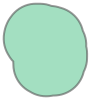

In [16]:
kcmo_simple

In [17]:
kcmo_simple.centroid.wkt

'POINT (-94.56097259792114 39.10808543024518)'

In [18]:
def kc(poi):
    """
    Returns True if the POI is inside the KCMO shape file
    """
    latitude, longitude = poi[1][0], poi[1][1]
    return city.value.intersects(Point(longitude, latitude))

In [19]:
kc_poi = poi.filter(kc)
#kc_poi.count()
# Out of the 25419 poi's that have Kansas City as their address, 18148 are located within the KC shape file
# 23989 are located within the KC shape file with buffer = 0.1
# 22146 are located within the KC shape file with buffer = 0.01
# 23741 are located within the KC shape file with buffer = 0.025

In [8]:
kc_poi.take(1)

[(u'7098', [39.842443, -94.793003, u'Brake Service & Repair', u'I', 7539])]

In [20]:
kc_poi2 = kc_poi.map(lambda x: (Point(x[1][1], x[1][0]), x[1][2:]))

In [18]:
poi = kc_poi2.take(1)

In [21]:
kc_poi_list = sc.broadcast(kc_poi2.collect())

In [22]:
locations = sc.textFile("hdfs://cls04pri/user/vvelocci/locations_in_kcmo_by_subid.txt")
locations = locations.map(literal_eval).cache()

In [59]:
l = locations.take(5)
l

[(u'54fac2fab60c1d52c81628493aecba8a',
  [{'geometry': {'coordinates': [[[-94.5795, 39.194],
       [-94.5794, 39.1932],
       [-94.5791, 39.1925],
       [-94.5779, 39.1921],
       [-94.5762, 39.1926],
       [-94.5761, 39.1932],
       [-94.5761, 39.1933],
       [-94.5795, 39.194]]],
     'type': 'Polygon'},
    'properties': {'geom_id': 0,
     'geom_type': 'Location',
     'time_spent': 0,
     'times': []},
    'type': 'Feature'}]),
 (u'8940248df75fa221ec44f7bc2b71316a',
  [{'geometry': {'coordinates': [[-94.5813, 39.27], [-94.5797, 39.2612]],
     'type': 'LineString'},
    'properties': {'geom_id': 0,
     'geom_type': 'Location',
     'time_spent': 8889,
     'times': [['2017-04-30 00:00:00', '2017-04-30 00:33:46.665000'],
      ['2017-04-30 04:21:02.126000', '2017-04-30 04:44:16.668000'],
      ['2017-04-30 07:54:47.767000', '2017-04-30 07:56:30.794000'],
      ['2017-04-30 12:03:31.157000', '2017-04-30 12:14:58.845000'],
      ['2017-04-30 13:06:24.208000', '2017-04-30 13:

In [63]:
# buf = Point(-94.5794, 39.1932).buffer(0.0065) # 0.0065 corresponds to approximately 0.37 miles ~ 600 m
# list(buf.exterior.coords)

In [24]:
#locations.count()
# 545309

In [25]:
# Find centroid of location object, form a buffer around it of a certain distance, find all the poi's that intersect
# the buffer region, classify the location as being the industry code associated w/ the most number of poi's in region.

In [23]:
def nonzero(location):
    """
    Filters out locations with dwell times of
    zero
    """
    locations = []
    for loc in location[1]:
        if loc['properties']['time_spent'] > 0:
            locations.append(loc)
    return (location[0], locations)

def centroid(location):
    """
    For each location object, forms a Shape object from the 
    location geometry, calculates the centroid of the geometry,
    and returns a new location object with 'centroid':centroid
    key, value pair added to it.
    """
    for loc in location[1]:
        geometry = loc['geometry']
        shape = asShape(geometry)
        coordinates = list(shape.centroid.coords)[0]
        loc['centroid'] = Point(coordinates)
    return location

# We can use regular buffer (Euclidean) because relative error between Euclidean (D) and Great Circle Distance (L) is
# (L - D)/L which is approximately L^2/(24*R^2) where R is Earth's radius and where we expand sin(theta) to first two
# nonzero terms via its Taylor Series.  Using L = 1 mile, we get relative error of 2.6 x 10^-7 %
def form_buffer2(centroid, distance):
    """
    Returns a (Euclidean) buffer of radius distance
    about the centroid
    """
    return asShape(centroid).buffer(distance)

# def nearest_k(k, nearby, centroid):
#     distances = []
#     for poi in nearby:
#         distance = vincenty(list(centroid.coords)[0][::-1], list(poi[0].coords)[0][::-1])
#         distances.append(distance)
#     indices = sorted(range(len(distances)), key=lambda x: distances[x])
#     nearby = [nearby[i] for i in indices[:k]]
#     return nearby

# def nearby_pois2(k, distance, location):
#     centroid = location[1]['centroid']
#     buf = form_buffer2(centroid, distance)
#     nearby = []
#     for kc_poi in kc_poi_list.value:
#         if kc_poi[0].intersects(buf):
#             nearby.append(kc_poi)
#     if len(nearby) > 0:
#         return (location[0], location[1], nearest_k(k, nearby, centroid))
#     else:
#         return nearby_pois2(k, distance*1.25, location)

def nearby_pois3(k, buf_radius, miles, location):
    """
    Forms buffer about centroid, and finds all POIs that intersect
    the buffer and collects them in a list, nearby.
    For each POI in nearby, find the vincenty (Great Circle Distance) from
    centroid and if it is less than miles, keep it.
    Arrange them in ascending order of distance.
    Return user, location info, and (sorted) nearby
    Note: Even though I argued error between Euclidean and
    Great Circle distances is very small, I used vincenty distance since
    it was working.  Using pyproj to non-Euclidean buffers was not working
    for me.  Kept getting Python Egg errors, and 'list not found' errors"""
    centroid = location[1]['centroid']
    buf = form_buffer2(centroid, buf_radius)
    nearby = []
    for kc_poi in kc_poi_list.value:
        if kc_poi[0].intersects(buf):
            nearby.append(kc_poi)
    distances = []
    for poi in nearby:
        d = vincenty(list(centroid.coords)[0][::-1], list(poi[0].coords)[0][::-1]).miles
        if d <= miles:
            distances.append(d)
    indices = sorted(range(len(distances)), key=lambda x: distances[x])
    nearby = [nearby[i] for i in indices[:k]]
    return (location[0], location[1], nearby)

def bins(hour_dict):
    """
    Takes a dictionary of hour,frequency and returns
    a dictionary in which the keys are bins and the values are
    total timestamps occurring for that bin.  Here I chose 4 bins of length
    6 hours
    """
    bin_dict = collections.Counter()
    for hour,freq in hour_dict.items():
        if hour in range(0,6):
            bin_dict[0] += freq
        elif hour in range(6,12):
            bin_dict[1] += freq
        elif hour in range(12,18):
            bin_dict[2] += freq
        else:
            bin_dict[3] += freq
    return bin_dict

def parse_datetime(location):
    """Parses through every timestamp and makes a datetime object
    Forms a dictionary of hours, frequency pairs in which frequency
    is the total number of occurrences of that particular hour in the location
    object.
    Then, take that dictionary and return a bin dictionary in which each bin
    is of length 6 hours"""
    time_intervals = location[1]['properties']['times']
    hour_dict = collections.Counter()
    for time_interval in time_intervals:
        date1 = time_interval[0]
        date2 = time_interval[1]
        try:
            x = datetime.strptime(date1, '%Y-%m-%d %H:%M:%S.%f')
        except:
            date1 = date1 + '.0' # In case of whole number seconds
            x = datetime.strptime(date1, '%Y-%m-%d %H:%M:%S.%f')
        try:
            y = datetime.strptime(date2, '%Y-%m-%d %H:%M:%S.%f')
        except:
            date2 = date2 + '.0'
            y = datetime.strptime(date2, '%Y-%m-%d %H:%M:%S.%f')
        xhour, yhour = x.hour, y.hour
        hour_dict[xhour] += 1
        hour_dict[yhour] += 1
    bin_dict = bins(hour_dict)
    return dict(bin_dict)
    
# def nearby_pois(distance, k, location):
#     centroid = location[1]['centroid']
#     buf = form_buffer2(centroid, distance)
#     nearby = []
#     for kc_poi in kc_poi_list.value:
#         if kc_poi[0].intersects(buf):
#             nearby.append(kc_poi)
#     if len(nearby) < k:
#         return nearby_pois(distance*1.5, k, location)
#     elif len(nearby) > 2*k :
#         return nearby_pois(distance/2.0, k, location)
#     elif len(nearby) >= k and len(nearby) <= 2*k:
#         nearby = nearest_k(k, nearby, centroid)
#     return (location[0], location[1], nearby)

# def form_buffer(centroid, distance):
#     #Not working
#     srcProj = pyproj.Proj(init='/home/vvelocci/pyproj-1.9.5.1/lib/pyproj/data/EPSG:4326')
#     dstProj = pyproj.Proj(init='/home/vvelocci/pyproj-1.9.5.1/lib/pyproj/data/EPSG:5070')
#     pt1 = list(centroid.coords)[0]
#     x, y = pyproj.transform(srcProj, dstProj, pt1[0], pt1[1])
#     pt = Point(x,y)
#     buf = pt.buffer(distance)
#     buffer_points =  zip(buf.exterior.coords.xy[0], buf.exterior.coords.xy[1])
#     proj_buffer_points = []
#     for point in buffer_points:
#         x = point[0]
#         y = point[1]
#         x, y = pyproj.transform(dstProj, srcProj, x, y)
#         proj_buffer_points.append((x, y))

#     #print Polygon(proj_buffer_points)
#     #print Polygon(proj_buffer_points).intersects(Point(pt1))
#     #print Polygon(proj_buffer_points).contains(Point(pt1))
#     return Polygon(proj_buffer_points)

# def poi_in_buffer(poi):
#     centroid = location[1][0]['centroid']
#     buffer = form_buffer(centroid, distance)
#     latitude, longitude = poi[1][0], poi[1][1]
#     return city.value.intersects(Point(longitude, latitude))

# If distance = 0.01 for buffer around centroid, 33% of location buffers will not intersect ANY poi's. 
# 9% if distance = 0.1.  48% of industry codes are G (retail trade).

# def step2(location):
#     poi_codes = collections.Counter()
#     distance = 0.1 # Euclidean distance using long and lat as x and y coordinates
#     centroid = location[1][0]['centroid']
#     buffer = form_buffer(centroid, distance)
#     if location[1][0]['properties']['time_spent'] == 0:
#         location[1][0]['industry_code'] = 'waypoint/jump'
#         return location
#     else:
#         for kc_poi in kc_poi_list.value:
#             if kc_poi[0].intersects(buffer):
#                 poi_codes[kc_poi[1]] += 1
#         try:
#             industry_code = max(poi_codes.iteritems(), key=lambda x: x[1])[0]
#             location[1][0]['industry_code'] = industry_code
#         except:
#             location[1][0]['industry_code'] = "Nothing"
#     return location

# def polygon(location):
#     if location[1][0]['geometry']['type'] == 'Polygon':
#         return True
#     return False

# def poi_in_polygon(location):
#     for loc in location[1]:
#         centroid = loc['centroid']
#         # Find the closest poi to the centroid
#         # Then set loc['place'] = poi's 4-digit code and 8-digit codes
# def nearest(x):
#     nearby = x[2]
#     center = x[1]['centroid']
#     distances = []
#     cen_coordinates = list(center.coords)[0][::-1]
#     for place in nearby:
#         pt = place[0]
#         poi_coordinates = list(pt.coords)[0][::-1]
#         #description = place[1]
#         distance = vincenty(cen_coordinates, poi_coordinates)
#         distances.append(distance)
#     ind = distances.index(min(distances))
#     description = nearby[ind][1]
#     return description

file = open("complete_sic_dict.pickle",'r')
sic_dict = pickle.load(file)

def code_freq(location):
    """
    Returns a list of 4-digit SIC codes (and their descriptions)
    that occur the most frequent inside the buffer.
    If there is a tie, return all of them
    If no POIs are inside the buffer, return
    'no_code' and 'Too_Far_Away'
    """
    count = Counter()
    for poi in location[2]:
        count[poi[1][-1]] += 1
    try:
        highest = max(count.values())
        winning_code = [k for k, v in count.items() if v == highest]
        #winning_code = max(count, key=count.get)
        #try:
        codes1 = [i for i in winning_code if i in sic_dic.keys()]
        codes2 = [i for i in winning_code if i not in sic_dic.keys()]
        winning_description = [sic_dic[wc] for wc in codes1]
        winning_description.extend(codes2)
        #winning_description = sic_dict[winning_code]
        #except:
        #    winning_description = winning_code
    except:
        winning_code = 'no_code'
        winning_description = 'Too_Far_Away'
    return winning_description, winning_code

def nearest_poi(location):
    """
    Returns the nearest POI's description and
    4-digit SIC code.  It will be the first in the list called
    nearby
    """
    nearby = location[2]
    nearest_one = nearby[0]
    nearest_description = nearest_one[1][0]
    nearest_code = nearest_one[1][2]
    return nearest_description, nearest_code

def clf(location):
    """
    Attach the nearest POI's code and description
    and those of the POIs that occur most frequently
    to the location data
    """
    wd, wc = code_freq(location)
    if wd == 'Too_Far_Away':
        nd, nc = 'Too_Far_Away', 'Too_Far_Away'
    else:
        nd, nc = nearest_poi(location)
    location[1]['centroid'] = list(location[1]['centroid'].coords)[0]
    d = {'nearest_code': nc, 'nearest': nd, 'most_freq_code': wc, 'most_freq': wd}
    return (location[0], location[1], d)

def clf2(location):
    """
    Attach centroid, time_spent, geometry_type, geom_id, bin_dict
    to eac location data for each user
    """
    d = location[2]
    d['centroid'] = location[1]['centroid']
    d['time_spent'] = location[1]['properties']['time_spent']
    d['geometry_type'] = location[1]['geometry']['type']
    d['geom_id'] = location[1]['properties']['geom_id']
    # Commented out because keeping them in results in something I can't use literal_eval on when doing
    # sc.textFile('file_path')
    bin_dict = parse_datetime(location)
    d['parts_of_day'] = bin_dict
    return (location[0], d)

In [24]:
nonzero_loc_cent = locations.map(nonzero).map(centroid).flatMapValues(lambda x: x).map(lambda location: nearby_pois3(5, 0.007, 0.37, location))

In [22]:
n = nonzero_loc_cent.take(1)

In [24]:
location = n[0]

In [27]:
location[2][0][1][2]

[u'Physicians & Surgeons Sclerotherapy', u'J', u'8011']

In [25]:
classification = nonzero_loc_cent.map(clf) # 1708993 locations
classification2 = classification.map(clf2)

In [67]:
x = classification.take(1)[0]

In [68]:
x[1]

{'centroid': (-94.5805, 39.265600000000006),
 'geometry': {'coordinates': [[-94.5813, 39.27], [-94.5797, 39.2612]],
  'type': 'LineString'},
 'properties': {'geom_id': 0,
  'geom_type': 'Location',
  'time_spent': 8889,
  'times': [['2017-04-30 00:00:00', '2017-04-30 00:33:46.665000'],
   ['2017-04-30 04:21:02.126000', '2017-04-30 04:44:16.668000'],
   ['2017-04-30 07:54:47.767000', '2017-04-30 07:56:30.794000'],
   ['2017-04-30 12:03:31.157000', '2017-04-30 12:14:58.845000'],
   ['2017-04-30 13:06:24.208000', '2017-04-30 13:15:52.024000'],
   ['2017-04-30 14:44:22.376000', '2017-04-30 15:26:12.600000'],
   ['2017-04-30 23:33:19.899000', '2017-05-01 00:00:00']]},
 'type': 'Feature'}

In [69]:
classification_data = classification.map(lambda x: (x[0], x[2]['nearest'], x[2]['most_freq'], x[1]['centroid'], x[1]['properties']['time_spent'], x[1]['geometry']['type'],x[1]['properties']['geom_id']))
classificationData = hc.createDataFrame(classification_data, ['id', 'nearest', 'most_freq', 'centroid', 'time_spent', 'geom_type', 'geom_id'])

In [26]:
"""
Not being very creative here, I apologize
I am combining the location objects for each user and grouping them
by subid
"""
def blah(x):
    return [x]
def blah2(x,y):
    x.append(y)
    return x
def blah3(x,y):
    x.extend(y)
    return x

classification3 = classification2.combineByKey(blah, blah2, blah3)

In [52]:
cl = classification3.take(5)

In [53]:
cl

[(u'8940248df75fa221ec44f7bc2b71316a',
  [{'centroid': (-94.5805, 39.265600000000006),
    'geom_id': 0,
    'geometry_type': 'LineString',
    'most_freq': 'Too_Far_Away',
    'most_freq_code': 'no_code',
    'nearest': 'Too_Far_Away',
    'nearest_code': 'Too_Far_Away',
    'parts_of_day': {0: 5, 1: 2, 2: 6, 3: 1},
    'time_spent': 8889},
   {'centroid': (-94.56874841630834, 39.224798797559764),
    'geom_id': 1,
    'geometry_type': 'Polygon',
    'most_freq': 'Too_Far_Away',
    'most_freq_code': 'no_code',
    'nearest': 'Too_Far_Away',
    'nearest_code': 'Too_Far_Away',
    'parts_of_day': {0: 3, 1: 3, 2: 6, 3: 2},
    'time_spent': 38537},
   {'centroid': (-94.58683462812405, 39.16465903342366),
    'geom_id': 2,
    'geometry_type': 'Polygon',
    'most_freq': 'Too_Far_Away',
    'most_freq_code': 'no_code',
    'nearest': 'Too_Far_Away',
    'nearest_code': 'Too_Far_Away',
    'parts_of_day': {1: 2, 2: 2},
    'time_spent': 9104},
   {'centroid': (-94.5818, 39.2458),
    'ge

In [ ]:
classification3.saveAsTextFile("hdfs://cls04pri/user/vvelocci/classification3.txt")

In [17]:
classification3 = sc.textFile("hdfs://cls04pri/user/vvelocci/classification3.txt")
classification3 = classification3.map(literal_eval).cache()

In [55]:
classification3.take(1)

[(u'8940248df75fa221ec44f7bc2b71316a',
  [{'centroid': (-94.5805, 39.265600000000006),
    'geom_id': 0,
    'geometry_type': 'LineString',
    'most_freq': u'DANCE STUDIOS, SCHOOLS, AND HALLS',
    'nearest': u'Physicians & Surgeons Sclerotherapy',
    'parts_of_day': {0: 5, 1: 2, 2: 6, 3: 1},
    'time_spent': 8889},
   {'centroid': (-94.56874841630834, 39.224798797559764),
    'geom_id': 1,
    'geometry_type': 'Polygon',
    'most_freq': u'RELIGIOUS ORGANIZATIONS',
    'nearest': u'Churches Baptist Independent',
    'parts_of_day': {0: 3, 1: 3, 2: 6, 3: 2},
    'time_spent': 38537},
   {'centroid': (-94.58683462812405, 39.16465903342366),
    'geom_id': 2,
    'geometry_type': 'Polygon',
    'most_freq': u'AUTOMOTIVE DEALERS',
    'nearest': u'Dentist Oral Surgery',
    'parts_of_day': {1: 2, 2: 2},
    'time_spent': 9104},
   {'centroid': (-94.5818, 39.2458),
    'geom_id': 6,
    'geometry_type': 'Point',
    'most_freq': u'OPTICAL GOODS STORES',
    'nearest': u'Dentists',
    '

In [6]:
def too_far_count(user):
    """
    Counts how many 0.4 mile buffers contain/don't contain
    any POIs
    """
    sum = 0
    for place in user[1]:
        if place['nearest'] != 'Too_Far_Away':
            sum += 1
    return (user[0], sum)
classification3.map(too_far_count).map(lambda x: x[1]).reduce(lambda x,y: x+y)

863727

In [5]:
classification3.count()  # 845266 too far away, 863727 not too far away, 434357 total users

434357

In [19]:
def user_dist(user):
    count_freq = collections.Counter()
    count_nearest = collections.Counter()
    for loc in user[1]:
        near = loc['nearest']
        freq = loc['most_freq']
        count_freq[freq] += 1
        count_nearest[near] += 1
    return (user[0], count_freq, count_nearest)

In [20]:
user_distro = classification3.map(user_dist)

In [21]:
user_distro.take(20)

[(u'8940248df75fa221ec44f7bc2b71316a',
  Counter({u'AUTOMOTIVE DEALERS': 1,
           u'DANCE STUDIOS, SCHOOLS, AND HALLS': 1,
           u'GENERAL WAREHOUSING AND STORAGE': 1,
           u'OPTICAL GOODS STORES': 1,
           u'RELIGIOUS ORGANIZATIONS': 1}),
  Counter({u'Churches Baptist Independent': 1,
           u'Dentist Oral Surgery': 1,
           u'Dentists': 1,
           u'Physicians & Surgeons Sclerotherapy': 1,
           u'Warehouses Commodity & Merchandise': 1})),
 (u'449bef183516ff0b3fb6fd2cb1cfcd01',
  Counter({'Too_Far_Away': 3}),
  Counter({'Too_Far_Away': 3})),
 (u'f888d70cd2f09af040940aa1822978b8',
  Counter({u'ELEMENTARY AND SECONDARY SCHOOLS': 1, 'Too_Far_Away': 1}),
  Counter({u'Schools Public': 1, 'Too_Far_Away': 1})),
 (u'86b4e9d05dc7cab60488d7ee6f46b280',
  Counter({u'RETAIL BAKERIES': 1, 'Too_Far_Away': 3}),
  Counter({u'Physicians - General': 1, 'Too_Far_Away': 3})),
 (u'618ae825d187b1e633929e799c5f5c99',
  Counter({u'HOUSEHOLD APPLIANCE STORES': 1}),
  Cou

In [141]:
user = classification3.take(1)[0]

In [170]:
def too_far(user):
    locations = user[1]
    stuff = []
    for location in locations:
        if location['nearest'] == 'Too_Far_Away':
            d = location['parts_of_day']
            t = location['time_spent']
            stuff.extend([d,t])
    return (user[0], stuff)

def too_far2(user):
    locations = user[1]
    parts_of_day = collections.Counter()
    for location in locations:
        if location['nearest'] == 'Too_Far_Away':
            d = location['parts_of_day']
            for b,f in d.items():
                parts_of_day[b] += f
    return (user[0], parts_of_day)

In [181]:
tf = classification3.map(too_far2).filter(lambda x: len(x[1]) > 0)
def meh1(user):
    d = user[]
    od = collections.OrderedDict(sorted(d.items()))

In [ ]:
#-------------------NOTHING MORE TO SEE HERE, JUST MISC STUFF-------------------------

In [26]:
# zero_time = loc_cent.filter(lambda location: location[1][0]['properties']['time_spent'] == 0) # 128051
# nonzero_time = loc_cent.filter(lambda location: location[1][0]['properties']['time_spent'] > 0) # 417258

In [132]:
# Distribution of shape types for locations with nonzero time_spent.
shapes = collections.Counter()
for location in nonzero_time.collect():
    x = location[1][0]['geometry']['type']
    shapes[x] += 1
shapes
# 'LineString': 34013, 'Point': 79873, 'Polygon': 303372

Counter({'LineString': 34013, 'Point': 79873, 'Polygon': 303372})

In [133]:
# Distribution of shape types for locations with zero time_spent.
shapes = collections.Counter()
for location in zero_time.collect():
    x = location[1][0]['geometry']['type']
    shapes[x] += 1
shapes
# 'LineString': 19258, 'Point': 36723, 'Polygon': 72070

Counter({'LineString': 19258, 'Point': 36723, 'Polygon': 72070})

In [ ]:
point1 = Point(50.67,4.62)
point2 = Point(51.67, 4.64)
import math
# Euclidean Dustance
def Euclidean_distance(point1,point2):
     return math.sqrt((point2.x()-point1.x())**2 + (point2.y()-point1.y())**2)

print Euclidean_distance(point1,point2)
1.00019998 # distance in degrees (coordinates of the points in degrees)

# with Shapely
print point1.distance(point2)
1.0001999800039989 #distance in degrees (coordinates of the points in degrees)

In [40]:
y = asShape(geometry['geometry'])
y.contains(Point(0.5, 0.5))

def close(poi, geometry):
    poi_point = Point(poi[1][0])
    y = asShape(geometry['geometry'])
    return y.contains(poi_point)

In [39]:
# close_poi = kcmo_lines5.filter(lambda poi: close(poi, geometry))
# close_poi.collect()

In [44]:
#[isinstance(l, int) for l in x]

In [46]:
# The only years that coincide with the first 4 digits of sic codes are 2011, 2013, and 2015.
# Count the number of poi's that have any of these years in the first 4 digits of their sic codes.
# Answer = 0.  Therefore, we may remove all 8 digit numbers that begin with years from 1980 - 2017 since
# they don't correspond to sic codes, aside from 2011, 2013, and 2015, which aren't in the dataset anyway.
rdd = kcmo_lines.map(find_all_8).filter(lambda x: any(j in x[0] for j in ['2011','2013','2015'])).count()

In [18]:
#indices = [i for i, x in enumerate(my_list) if x == 'whatever']

In [157]:
#poi_spark = kcmo_lines4.toDF()
#poi = poi_spark.toPandas()
#poi.columns = ['lat', 'long', 'type']
#poi.head()

In [132]:
# See if there are any pois in which there are at least three codes beginning with any from range(2000,2018).
# If not, then they are dates, not sic codes, and can be discarded
thingsToCheck = [str(x) for x in range(2000,2018)]
for blah in poi:
    sum = 0
    stuff = blah[1][2:] # The first two elements are lat/long
    foo = []
    for x in stuff:
        if any(date in x for date in thingsToCheck):
            sum += 1
    if sum >= 3:
        foo.append(sum)
# foo is empty, so they are all dates.  They can be discarded.

In [133]:
def sic_code_keep(place):
    thingsToCheck = [str(x) for x in range(2000,2018)]
    id = place[0]
    stuff = place[1][3:]
    lat_long_business = [(place[1][0], place[1][1]), place[1][2]]
    for x in stuff:
        if not any(date in x for date in thingsToCheck):
            lat_long_business.append(x)
    return (id, lat_long_business)

In [134]:
# Reverses the lat-long entries to match with those in locations data
def reverse(place):
    new_lat_long = [place[1][0][::-1]]
    new_lat_long.extend(place[1][1:])
    return (place[0], new_lat_long)